In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Player Data

In [2]:
players = pd.read_csv('../Resources/tennis_atp-master/atp_players.csv', 
                      header=None,
                      names=['player_id', 'name_first', 'name_last', 'hand', 'birthdate', 'country'],
                      index_col='player_id')

# The format for birthdate is non-standard, and cannot be converted using parse_dates.
players['birthdate'] = pd.to_datetime(players.birthdate, format='%Y%m%d', errors='coerce')

players.info()
players.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55005 entries, 100001 to 209970
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   name_first  54828 non-null  object        
 1   name_last   54963 non-null  object        
 2   hand        49227 non-null  object        
 3   birthdate   43474 non-null  datetime64[ns]
 4   country     54950 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 2.5+ MB


,name_first,name_last,hand,birthdate,country
player_id,,,,,
100001,Gardnar,Mulloy,R,1913-11-22,USA
100002,Pancho,Segura,R,1921-06-20,ECU
100003,Frank,Sedgman,R,1927-10-02,AUS
100004,Giuseppe,Merlo,R,1927-10-11,ITA
100005,Richard Pancho,Gonzales,R,1928-05-09,USA


In [3]:
# L = Left handed
# R = Right handed
# A = Ambidextrous
# U = Unknown

players.hand.value_counts(dropna=False)

U      32578
R      15276
NaN     5778
L       1372
A          1
Name: hand, dtype: int64

In [4]:
# NaN values can be safely converted to U, which represents an unknown value.

players.hand.fillna('U', inplace=True)
players.hand = players.hand.astype('category')

In [5]:
#players.to_csv('../Resources/tennis_clean/atp_players.csv')

## Ranking Data

In [6]:
ranking_files = glob.glob('../Resources/tennis_atp-master/atp_rankings_[0-9]*')

In [7]:
rankings_list = [pd.read_csv(ranking_file, parse_dates=['ranking_date']) for ranking_file in ranking_files]
rankings_current = pd.read_csv('../Resources/tennis_atp-master/atp_rankings_current.csv',
                               names=['ranking_date', 'rank', 'player', 'points'], parse_dates=['ranking_date'])
rankings_list.append(rankings_current)

In [8]:
rankings = pd.concat(rankings_list)

# 'rank' is a pandas function, so take care not to name any columns as such.
rankings.columns = ['ranking_date', 'player_rank', 'player_id', 'points']

rankings.player_rank = rankings.player_rank.astype('Int64')
rankings.points = rankings.points.astype('Int64')

rankings.set_index('player_id', inplace=True)

rankings.info()
rankings.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2908309 entries, 101736 to 108705
Data columns (total 3 columns):
 #   Column        Dtype         
---  ------        -----         
 0   ranking_date  datetime64[ns]
 1   player_rank   Int64         
 2   points        Int64         
dtypes: Int64(2), datetime64[ns](1)
memory usage: 94.3 MB


,ranking_date,player_rank,points
player_id,,,
101736,2000-01-10,1,4135
102338,2000-01-10,2,2915
101948,2000-01-10,3,2419
103017,2000-01-10,4,2184
102856,2000-01-10,5,2169


In [9]:
rankings.duplicated().value_counts()

False    1644678
True     1263631
dtype: int64

In [10]:
rankings['player_age'] = rankings.ranking_date - players.loc[rankings.index].birthdate

rankings.reset_index(inplace=True)
rankings.set_index(['player_id', 'ranking_date'], inplace=True)
rankings.sort_index(inplace=True)

rankings.info()
rankings.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2908309 entries, (100001, Timestamp('1977-07-04 00:00:00')) to (209955, Timestamp('2021-03-01 00:00:00'))
Data columns (total 3 columns):
 #   Column       Dtype          
---  ------       -----          
 0   player_rank  Int64          
 1   points       Int64          
 2   player_age   timedelta64[ns]
dtypes: Int64(2), timedelta64[ns](1)
memory usage: 83.3 MB


player_rank  points player_age
player_id ranking_date                                
100001    1977-07-04            366    <NA> 23235 days
          1978-01-02            414    <NA> 23417 days
          1978-01-16            397    <NA> 23431 days
100002    1975-03-10            355    <NA> 19621 days
          1975-04-14            383    <NA> 19656 days

In [11]:
rankings['best_rank'] = (rankings.reset_index()
                                .groupby('player_id')
                                .player_rank.cummin()
                                .astype('Int64')
                                .values)

rankings.info()
rankings.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2908309 entries, (100001, Timestamp('1977-07-04 00:00:00')) to (209955, Timestamp('2021-03-01 00:00:00'))
Data columns (total 4 columns):
 #   Column       Dtype          
---  ------       -----          
 0   player_rank  Int64          
 1   points       Int64          
 2   player_age   timedelta64[ns]
 3   best_rank    Int64          
dtypes: Int64(3), timedelta64[ns](1)
memory usage: 108.3 MB


player_rank  points player_age  best_rank
player_id ranking_date                                           
100001    1977-07-04            366    <NA> 23235 days        366
          1978-01-02            414    <NA> 23417 days        366
          1978-01-16            397    <NA> 23431 days        366
100002    1975-03-10            355    <NA> 19621 days        355
          1975-04-14            383    <NA> 19656 days        355

In [12]:
#rankings.to_csv('../Resources/tennis_clean/atp_rankings.csv')

## Top 100 Data

In [13]:
top_rankings = rankings.groupby('player_id').filter(lambda x: x.player_rank.min() <= 100)

In [14]:
top_rankings.reset_index('ranking_date').index.unique().size

1106

In [15]:
top_rankings = top_rankings.reset_index('ranking_date')
top_rankings.info()
top_rankings.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550853 entries, 100011 to 206173
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype          
---  ------        --------------   -----          
 0   ranking_date  550853 non-null  datetime64[ns] 
 1   player_rank   550853 non-null  Int64          
 2   points        452310 non-null  Int64          
 3   player_age    550369 non-null  timedelta64[ns]
 4   best_rank     550853 non-null  Int64          
dtypes: Int64(3), datetime64[ns](1), timedelta64[ns](1)
memory usage: 26.8 MB


,ranking_date,player_rank,points,player_age,best_rank
player_id,,,,,
100011,1973-08-27,114,<NA>,14937 days,114
100011,1973-09-17,114,<NA>,14958 days,114
100011,1973-10-01,101,<NA>,14972 days,101
100011,1973-10-15,96,<NA>,14986 days,96
100011,1973-11-05,102,<NA>,15007 days,96


In [16]:
top_100 = top_rankings.index.unique()

In [17]:
top_100_players = players.loc[top_100]
top_100_players.head()

,name_first,name_last,hand,birthdate,country
player_id,,,,,
100011,Torben,Ulrich,L,1932-10-04,DEN
100016,Ken,Rosewall,R,1934-11-02,AUS
100022,Roy,Emerson,R,1936-11-03,AUS
100025,Barry,Phillips Moore,R,1937-07-09,AUS
100026,Andres,Gimeno,R,1937-08-03,ESP


In [18]:
#top_rankings.to_csv('../Resources/tennis_clean/atp_top_100_rankings.csv')

In [19]:
#top_100_players.to_csv('../Resources/tennis_clean/atp_top_100_players.csv')

## Match Data

In [20]:
# I don't want any of the challenger or future match data, which is why I specify the first digit of the year.
matches_files = glob.glob('../Resources/tennis_atp-master/atp_matches_[12]*')

In [21]:
matches_list = [pd.read_csv(matches_file, parse_dates=['tourney_date']) for matches_file in matches_files]

In [22]:
matches = pd.concat(matches_list, sort=False)

In [23]:
matches.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

In [24]:
matches_winners = matches[['tourney_id', 'match_num', 'tourney_name',
                           'surface', 'draw_size', 'tourney_level', 'tourney_date',
                           'winner_id', 'winner_name', 'loser_id', 'loser_name',
                           'winner_seed', 'winner_entry', 'loser_seed', 'loser_entry',
                           'score', 'best_of', 'round', 'minutes',
                           'w_ace', 'w_df', 'w_svpt', 'l_ace', 'l_df', 'l_svpt',
                           'w_1stIn', 'w_1stWon', 'w_2ndWon', 'l_1stIn', 'l_1stWon', 'l_2ndWon',
                           'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
                           'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points',
                           'winner_ht', 'loser_ht']].copy()

In [25]:
matches_losers = matches[['tourney_id', 'match_num', 'tourney_name',
                           'surface', 'draw_size', 'tourney_level', 'tourney_date',
                           'loser_id', 'loser_name', 'winner_id', 'winner_name',
                           'loser_seed', 'loser_entry', 'winner_seed', 'winner_entry',
                           'score', 'best_of', 'round', 'minutes',
                           'l_ace', 'l_df', 'l_svpt', 'w_ace', 'w_df', 'w_svpt',
                           'l_1stIn', 'l_1stWon', 'l_2ndWon', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
                           'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'w_SvGms', 'w_bpSaved', 'w_bpFaced',
                           'loser_rank', 'loser_rank_points', 'winner_rank', 'winner_rank_points',
                           'loser_ht', 'winner_ht']].copy()

In [26]:
renamed_columns = (['tournament_id', 'match_id', 'tournament_name',
                    'surface', 'draw_size', 'tournament_level', 'tournament_date',
                    'player_id', 'player_name', 'opponent_id', 'opponent_name',
                    'player_seed', 'player_entry', 'opponent_seed', 'opponent_entry',
                    'score', 'best_of', 'round_of', 'minutes',
                    'aces', 'double_faults', 'service_points',
                    'opponent_aces', 'opponent_double_faults', 'opponent_service_points',
                    'first_serves', 'first_serves_won', 'second_serves_won',
                    'opponent_first_serves', 'opponent_first_serves_won', 'opponent_second_serves_won',
                    'service_games', 'break_points_saved', 'break_points_faced',
                    'opponent_service_games', 'opponent_break_points_saved', 'opponent_break_points_faced',
                    'player_rank', 'player_ranking_points', 'opponent_rank', 'opponent_ranking_points',
                    'player_height', 'opponent_height'])

matches_winners.columns = renamed_columns
matches_losers.columns = renamed_columns

In [27]:
matches_winners['result'] = 'W'
matches_losers['result'] = 'L'

In [28]:
matches = pd.concat([matches_winners, matches_losers])
matches.set_index(['player_id', 'tournament_id', 'match_id'], inplace=True)

## Data Cleaning

In [29]:
# Corrections to errant data here
# 1. 1991 Tokyo Outdoor tournament has an impossible value for Jim Courier's break point values.
#    Fix: An analysis of the score shows that the values are offset by 4. These are corrected.
# Courier
matches.loc[(101793, '1991-329', 54), 'break_points_faced'] = 4.
matches.loc[(101793, '1991-329', 54), 'break_points_saved'] = 0.
# Courier
matches.loc[(100656, '1991-329', 54), 'opponent_break_points_faced'] = 4.
matches.loc[(100656, '1991-329', 54), 'opponent_break_points_saved'] = 0.
# 2. 1991 Tokyo Outdoor tournament has an impossible value for Ivan Lendl's break point values.
#    Fix: The score has too many possibilities to narrow it down, so I will set the break points to NaN to avoid
#    propogating the errors any farther down the pipeline.
# Lendl
matches.loc[(100656, '1991-329', 55), 'break_points_faced'] = np.nan
matches.loc[(100656, '1991-329', 55), 'break_points_saved'] = np.nan
# Edberg
matches.loc[(101222, '1991-329', 55), 'opponent_break_points_faced'] = np.nan
matches.loc[(101222, '1991-329', 55), 'opponent_break_points_saved'] = np.nan

# Lendl must have distracted stat taker, as these are the only two individual instances of mistakes in the dataset.

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [30]:
# 3. The 2003 Madrid Masters has many instances where the service points won column 
#    exceeds the total service points played. All instances of service points
#    played and won are set to NaN for this tournament.
# 'service_points', 'first_serves', 'first_serves_won', 'second_serves_won'

madrid_2003_matches = matches.query('tournament_id == \'2003-1536\'').index
matches.loc[madrid_2003_matches, 'service_points'] = np.nan
matches.loc[madrid_2003_matches, 'first_serves'] = np.nan
matches.loc[madrid_2003_matches, 'first_serves_won'] = np.nan
matches.loc[madrid_2003_matches, 'second_serves_won'] = np.nan
matches.loc[madrid_2003_matches, 'opponent_service_points'] = np.nan
matches.loc[madrid_2003_matches, 'opponent_first_serves'] = np.nan
matches.loc[madrid_2003_matches, 'opponent_first_serves_won'] = np.nan
matches.loc[madrid_2003_matches, 'opponent_second_serves_won'] = np.nan

In [31]:
long_long_matches = matches.query('tournament_id == \'2016-M001\' and match_id == 294 \
                                or tournament_id == \'2017-0308\' and match_id == 297').index
matches.loc[long_long_matches, 'minutes'] = np.nan

## Feature Generation

(0.5989499144863037, 0.5981308411214953, 0.0, 1.0)

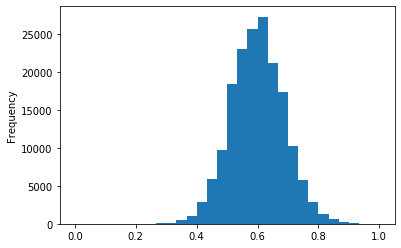

In [32]:
matches['first_serve_percentage'] = matches.first_serves / matches.service_points
matches['opponent_first_serve_percentage'] = matches.opponent_first_serves / matches.opponent_service_points

matches.first_serve_percentage.plot(kind='hist', bins=30)

(matches.first_serve_percentage.mean(), matches.first_serve_percentage.median(),
 matches.first_serve_percentage.min(), matches.first_serve_percentage.max())

(0.7103110356134068, 0.7142857142857143, 0.0, 1.0)

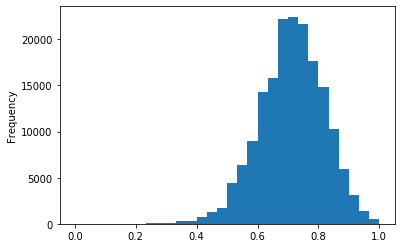

In [33]:
matches['first_serves_won_percentage'] = matches.first_serves_won / matches.first_serves
matches['opponent_first_serves_won_percentage'] = matches.opponent_first_serves_won / matches.opponent_first_serves

matches.first_serves_won_percentage.plot(kind='hist', bins=30)

(matches.first_serves_won_percentage.mean(), matches.first_serves_won_percentage.median(),
matches.first_serves_won_percentage.min(), matches.first_serves_won_percentage.max())

In [34]:
matches['second_serves'] = (matches.service_points - matches.first_serves)
matches['opponent_second_serves'] = (matches.opponent_service_points - matches.opponent_first_serves)

(0.5050139335937774, 0.5, 0.0, 1.0)

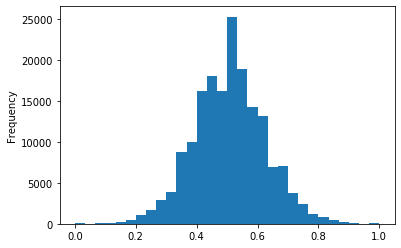

In [35]:
matches['second_serves_won_percentage'] = matches.second_serves_won / matches.second_serves
matches['opponent_second_serves_won_percentage'] = (matches.opponent_second_serves_won / 
                                                    matches.opponent_second_serves)

matches.second_serves_won_percentage.plot(kind='hist', bins=30)

(matches.second_serves_won_percentage.mean(), matches.second_serves_won_percentage.median(),
matches.second_serves_won_percentage.min(), matches.second_serves_won_percentage.max())

(0.5777339791379498, 0.6, 0.0, 1.0)

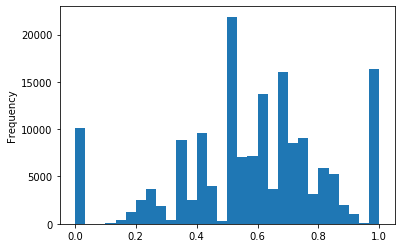

In [36]:
matches['break_points_saved_percentage'] = (matches.break_points_saved / matches.break_points_faced)
matches['opponent_break_points_saved_percentage'] = (matches.opponent_break_points_saved / 
                                                    matches.opponent_break_points_faced)

matches.break_points_saved_percentage.plot(kind='hist', bins=30)

# Initially two data points resulted in a negative percentage, and were corrected. 
(matches.break_points_saved_percentage.mean(), matches.break_points_saved_percentage.median(),
 matches.break_points_saved_percentage.min(), matches.break_points_saved_percentage.max())

(0.42226602086208453, 0.4, 0.0, 1.0)

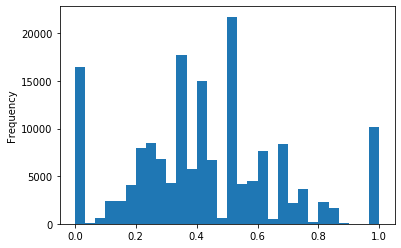

In [37]:
matches['break_points_won'] = matches.opponent_break_points_faced - matches.opponent_break_points_saved
matches['opponent_break_points_won'] = matches.break_points_faced - matches.break_points_saved

matches['break_points_won_percentage'] = (matches.break_points_won / 
                                          matches.opponent_break_points_faced)
matches['opponent_break_points_won_percentage'] = (matches.opponent_break_points_won / 
                                                   matches.break_points_faced)

matches.break_points_won_percentage.plot(kind='hist', bins=30)

# Initially two data points resulted in a negative percentage, and were corrected. 
(matches.break_points_won_percentage.mean(), matches.break_points_won_percentage.median(),
 matches.break_points_won_percentage.min(), matches.break_points_won_percentage.max())

(0.6264663910599169, 0.6285714285714286, 0.0, 1.0)

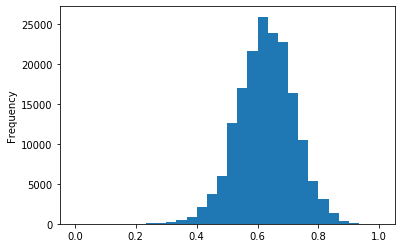

In [38]:
matches['service_points_won'] = matches.first_serves_won + matches.second_serves_won
matches['service_points_won_percentage'] = matches.service_points_won / matches.service_points

matches['opponent_service_points_won'] = (matches.opponent_first_serves_won + 
                                          matches.opponent_second_serves_won)
matches['opponent_service_points_won_percentage'] = (matches.opponent_service_points_won / 
                                                     matches.opponent_service_points)

matches.service_points_won_percentage.plot(kind='hist', bins=30)

(matches.service_points_won_percentage.mean(), matches.service_points_won_percentage.median(),
 matches.service_points_won_percentage.min(), matches.service_points_won_percentage.max())

(158.91444984635143, 148.0, 1.0, 980.0)

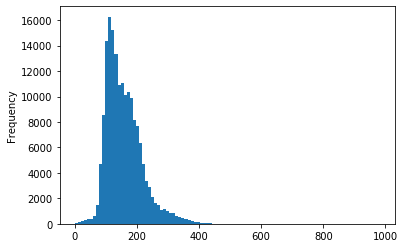

In [39]:
matches['points'] = matches.service_points + matches.opponent_service_points

matches.points.plot(kind='hist', bins=100)

matches.points.mean(), matches.points.median(), matches.points.min(), matches.points.max() 

(79.45722492317572, 74.0, 0.0, 491.0)

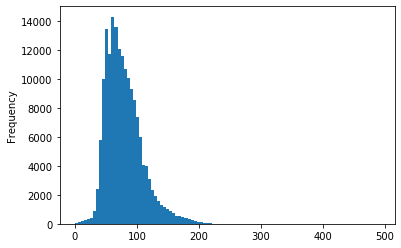

In [40]:
matches['return_points'] = matches.points - matches.service_points
matches['opponent_return_points'] = matches.points - matches.opponent_service_points

matches.return_points.plot(kind='hist', bins=100)

(matches.return_points.mean(), matches.return_points.median(),
matches.return_points.min(), matches.return_points.max())

(0.37353360894043813, 0.37142857142857144, 0.0, 1.0)

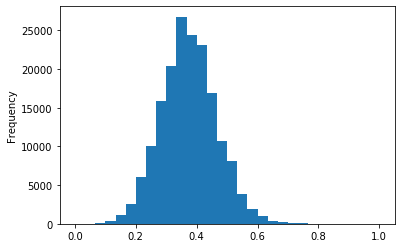

In [41]:
matches['return_points_won'] = matches.return_points - matches.opponent_service_points_won
matches['return_points_won_percentage'] = matches.return_points_won / matches.return_points

matches['opponent_return_points_won'] = matches.opponent_return_points - matches.service_points_won
matches['opponent_return_points_won_percentage'] = (matches.opponent_return_points_won / 
                                                    matches.opponent_return_points)

matches.return_points_won_percentage.plot(kind='hist', bins=30)

(matches.return_points_won_percentage.mean(), matches.return_points_won_percentage.median(),
matches.return_points_won_percentage.min(), matches.return_points_won_percentage.max())

(0.28968896438700814, 0.28968896438700814, 0.0, 1.0)

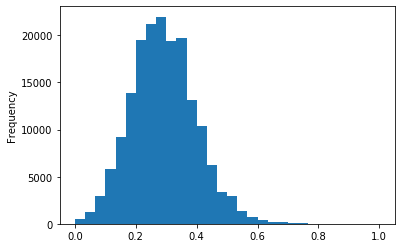

In [42]:
matches['first_serve_return_points_won'] = (matches.opponent_first_serves - 
                                            matches.opponent_first_serves_won)
matches['first_serve_return_points_won_percentage'] = (matches.first_serve_return_points_won / 
                                                       matches.opponent_first_serves)

matches['opponent_first_serve_return_points_won'] = (matches.first_serves - matches.first_serves_won)
matches['opponent_first_serve_return_points_won_percentage'] = (matches.opponent_first_serve_return_points_won / 
                                                                matches.first_serves)


matches.first_serve_return_points_won_percentage.plot(kind='hist', bins=30)

(matches.first_serve_return_points_won_percentage.mean(), matches.first_serve_return_points_won_percentage.mean(),
matches.first_serve_return_points_won_percentage.min(), matches.first_serve_return_points_won_percentage.max())

(0.49498606640587633, 0.0, 1.0)

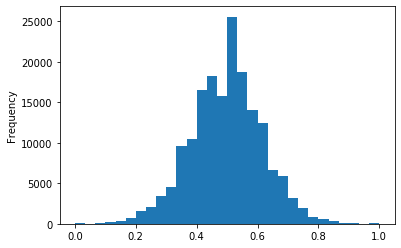

In [43]:
matches['second_serve_return_points_won'] = (matches.opponent_service_points - 
                                             matches.opponent_first_serves - 
                                             matches.opponent_second_serves_won)
matches['second_serve_return_points_won_percentage'] = (matches.second_serve_return_points_won / 
                                                        (matches.opponent_service_points - 
                                                         matches.opponent_first_serves))

matches['opponent_second_serve_return_points_won'] = (matches.service_points - 
                                                      matches.first_serves - 
                                                      matches.second_serves_won)
# loooong variable name alert
matches['opponent_second_serve_return_points_won_percentage'] = (matches.opponent_second_serve_return_points_won / 
                                                                 (matches.service_points - 
                                                                  matches.first_serves))


matches.second_serve_return_points_won_percentage.plot(kind='hist', bins=30)
matches.second_serve_return_points_won_percentage.mean(), matches.second_serve_return_points_won_percentage.min(), matches.second_serve_return_points_won_percentage.max()

(0.4999999999997953, 0.0, 1.0)

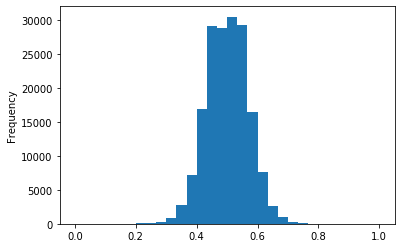

In [44]:
matches['points_won'] = matches.service_points_won + matches.return_points_won
matches['points_won_percentage'] = matches.points_won / matches.points

matches['opponent_points_won'] = matches.opponent_service_points_won + matches.opponent_return_points_won
matches['opponent_points_won_percentage'] = matches.opponent_points_won / matches.points

matches.points_won_percentage.plot(kind='hist', bins=30)

# I don't know what I expected.gif
matches.points_won_percentage.mean(), matches.points_won_percentage.min(), matches.points_won_percentage.max()

(0.0718519064893086, 0.05813953488372093, 0.0, 0.75)

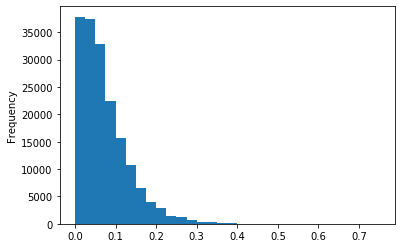

In [45]:
matches['ace_rate'] = matches.aces / matches.service_points
matches['opponent_ace_rate'] = matches.opponent_aces / matches.opponent_service_points

matches.ace_rate.plot(kind='hist', bins=30)

(matches.ace_rate.mean(), matches.ace_rate.median(),
 matches.ace_rate.min(), matches.ace_rate.max())

(0.039488617437303884, 0.034782608695652174, 0.0, 0.6666666666666666)

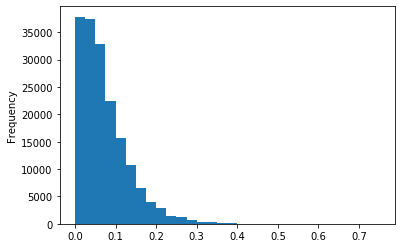

In [46]:
matches['double_fault_rate'] = matches.double_faults / matches.service_points
matches['opponent_double_fault_rate'] = matches.opponent_double_faults / matches.opponent_service_points

matches.ace_rate.plot(kind='hist', bins=30)

(matches.double_fault_rate.mean(), matches.double_fault_rate.median(),
 matches.double_fault_rate.min(), matches.double_fault_rate.max())

(0.03650695316640892, 0.03225806451612903, 0.0, 0.25)

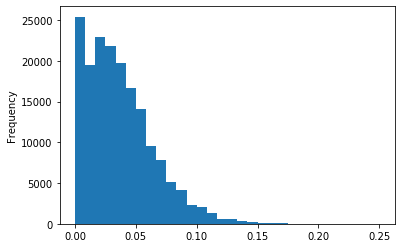

In [47]:
matches['break_rate'] = matches.break_points_won / matches.return_points
matches['opponent_break_rate'] = matches.opponent_break_points_won / matches.opponent_return_points

matches.break_rate.plot(kind='hist', bins=30)

# Initially two data points resulted in a negative percentage, and were corrected. 
(matches.break_rate.mean(), matches.break_rate.median(),
 matches.break_rate.min(), matches.break_rate.max())

(1.5823857361644726, 1.5425531914893618, 0.15384615384615385, 122.0)

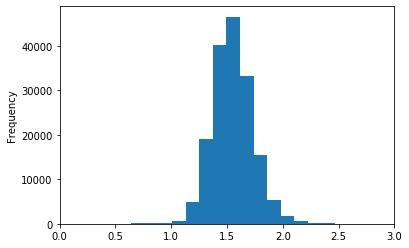

In [48]:
matches['points_per_minute'] = matches.points / matches.minutes

matches.points_per_minute.plot(kind='hist', bins=1000)
plt.xlim(0,3)

# Initially two data points resulted in a negative percentage, and were corrected. 
(matches.points_per_minute.mean(), matches.points_per_minute.median(),
 matches.points_per_minute.min(), matches.points_per_minute.max())

In [49]:
matches.columns

Index(['tournament_name', 'surface', 'draw_size', 'tournament_level',
       'tournament_date', 'player_name', 'opponent_id', 'opponent_name',
       'player_seed', 'player_entry', 'opponent_seed', 'opponent_entry',
       'score', 'best_of', 'round_of', 'minutes', 'aces', 'double_faults',
       'service_points', 'opponent_aces', 'opponent_double_faults',
       'opponent_service_points', 'first_serves', 'first_serves_won',
       'second_serves_won', 'opponent_first_serves',
       'opponent_first_serves_won', 'opponent_second_serves_won',
       'service_games', 'break_points_saved', 'break_points_faced',
       'opponent_service_games', 'opponent_break_points_saved',
       'opponent_break_points_faced', 'player_rank', 'player_ranking_points',
       'opponent_rank', 'opponent_ranking_points', 'player_height',
       'opponent_height', 'result', 'first_serve_percentage',
       'opponent_first_serve_percentage', 'first_serves_won_percentage',
       'opponent_first_serves_won_perce

In [54]:
matches[['player_name', 'opponent_name', 'tournament_name', 'surface', 'draw_size', 'tournament_level',
       'tournament_date', 'player_height', 'score', 'best_of',
       'round_of', 'minutes', 'aces', 'double_faults', 'service_points',
       'first_serves', 'first_serves_won', 'second_serves_won',
       'service_games', 'break_points_saved', 'break_points_faced',
       'player_rank', 'player_ranking_points', 'opponent_id', 'opponent_rank',
       'opponent_ranking_points', 'opponent_height', 'result', 'first_serve_percentage',
       'break_points_saved_percentage', 'service_points_won',
       'service_points_won_percentage', 'points', 'return_points',
       'return_points_won', 'return_points_won_percentage',
       'first_serves_won_percentage', 'second_serves_won_percentage',
       'first_serve_return_points_won',
       'first_serve_return_points_won_percentage',
       'second_serve_return_points_won',
       'second_serve_return_points_won_percentage', 'break_points_faced',
       'break_points_won', 'break_points_won_percentage', 'points_won',
       'points_won_percentage']]

,,,player_name,opponent_name,tournament_name,surface,draw_size,tournament_level,tournament_date,player_height,score,best_of,...,second_serves_won_percentage,first_serve_return_points_won,first_serve_return_points_won_percentage,second_serve_return_points_won,second_serve_return_points_won_percentage,break_points_faced,break_points_won,break_points_won_percentage,points_won,points_won_percentage
player_id,tournament_id,match_id,,,,,,,,,,,,,,,,,,,,,
105453,2019-M020,300,Kei Nishikori,Daniil Medvedev,Brisbane,Hard,32,A,2018-12-31,178.0,6-4 3-6 6-2,3,...,0.515152,20.0,0.370370,26.0,0.565217,6.0,5.0,0.333333,94.0,0.531073
106421,2019-M020,299,Daniil Medvedev,Jo-Wilfried Tsonga,Brisbane,Hard,32,A,2018-12-31,NaN,7-6(6) 6-2,3,...,0.736842,16.0,0.307692,18.0,0.720000,1.0,3.0,0.230769,76.0,0.589147
105453,2019-M020,298,Kei Nishikori,Jeremy Chardy,Brisbane,Hard,32,A,2018-12-31,178.0,6-2 6-2,3,...,0.642857,12.0,0.444444,13.0,0.684211,2.0,4.0,0.800000,60.0,0.645161
104542,2019-M020,297,Jo-Wilfried Tsonga,Alex De Minaur,Brisbane,Hard,32,A,2018-12-31,188.0,6-4 7-6(2),3,...,0.600000,22.0,0.366667,12.0,0.571429,5.0,2.0,0.333333,83.0,0.557047
106421,2019-M020,296,Daniil Medvedev,Milos Raonic,Brisbane,Hard,32,A,2018-12-31,NaN,6-7(2) 6-3 6-4,3,...,0.675676,10.0,0.178571,19.0,0.500000,8.0,2.0,0.500000,102.0,0.512563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105453,2014-605,514,Kei Nishikori,Novak Djokovic,Tour Finals,Hard,8,F,2014-11-09,178.0,6-1 3-6 6-0,3,...,0.172414,6.0,0.176471,11.0,0.458333,9.0,2.0,0.500000,51.0,0.408000
103819,2014-605,515,Roger Federer,Novak Djokovic,Tour Finals,Hard,8,F,2014-11-09,185.0,W/O,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104542,2014-D015,1,Jo-Wilfried Tsonga,Stan Wawrinka,Davis Cup WG F: FRA vs SUI,Clay,4,D,2014-11-21,188.0,6-1 3-6 6-3 6-2,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
matches.result = matches.result.astype('category')
matches.surface = matches.surface.astype('category')
matches.tournament_level = matches.tournament_level.astype('category')
matches.round_of = matches.round_of.astype('category')
matches.result = matches.result.astype('category')

In [56]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 355876 entries, (105453, '2019-M020', 300) to (104755, '2014-D015', 4)
Data columns (total 85 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   tournament_name                                     355876 non-null  object        
 1   surface                                             350602 non-null  category      
 2   draw_size                                           355876 non-null  int64         
 3   tournament_level                                    355876 non-null  category      
 4   tournament_date                                     355876 non-null  datetime64[ns]
 5   player_name                                         355876 non-null  object        
 6   opponent_id                                         355876 non-null  int64         
 7   opponent_name                           

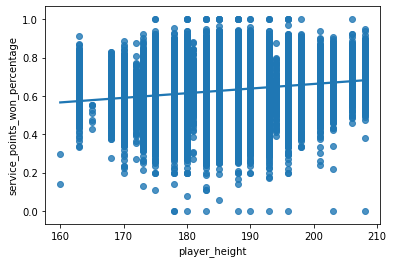

In [57]:
import seaborn as sns

sns.regplot(matches.player_height, matches.service_points_won_percentage)

In [58]:
matches['result_value'] = [1 if result == 'W' else 0 for result in matches.result]

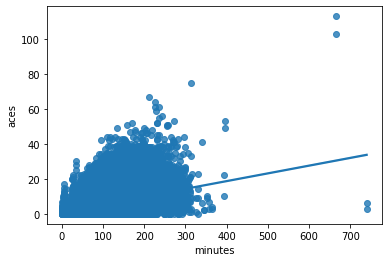

In [59]:
sns.regplot(matches.minutes, matches.aces)

In [63]:
COLUMNS = ['aces', 'double_faults',
       'first_serve_percentage', 'break_points_saved_percentage', 'service_points_won_percentage', 
       'return_points_won_percentage',
       'first_serves_won_percentage', 'second_serves_won_percentage',
       'first_serve_return_points_won_percentage',
       'second_serve_return_points_won_percentage', 
       'break_points_won_percentage',
       'points_won_percentage']

CAREER_COLUMNS = ['career_aces', 'career_double_faults',
       'career_first_serve_percentage', 'career_break_points_saved_percentage', 'career_service_points_won_percentage', 
       'career_return_points_won_percentage',
       'career_first_serves_won_percentage', 'career_second_serves_won_percentage',
       'career_first_serve_return_points_won_percentage',
       'career_second_serve_return_points_won_percentage', 
       'career_break_points_won_percentage',
       'career_points_won_percentage']

RECENT_COLUMNS = ['recent_aces', 'recent_double_faults',
       'recent_first_serve_percentage', 'recent_break_points_saved_percentage', 'recent_service_points_won_percentage', 
       'recent_return_points_won_percentage',
       'recent_first_serves_won_percentage', 'recent_second_serves_won_percentage',
       'recent_first_serve_return_points_won_percentage',
       'recent_second_serve_return_points_won_percentage', 
       'recent_break_points_won_percentage',
       'recent_points_won_percentage']

PAST_YEAR_COLUMNS = ['past_year_aces', 'past_year_double_faults',
       'past_year_first_serve_percentage', 'past_year_break_points_saved_percentage', 'past_year_service_points_won_percentage', 
       'past_year_return_points_won_percentage',
       'past_year_first_serves_won_percentage', 'past_year_second_serves_won_percentage',
       'past_year_first_serve_return_points_won_percentage',
       'past_year_second_serve_return_points_won_percentage', 
       'past_year_break_points_won_percentage',
       'past_year_points_won_percentage']

In [64]:
matches.reset_index(inplace=True)
matches.drop_duplicates(subset=['player_id', 'tournament_date', 'match_id'], inplace=True)
matches.drop_duplicates(subset=['player_id', 'tournament_date', 'opponent_id'], inplace=True)
matches.set_index(['player_id', 'tournament_date', 'match_id'], inplace=True)
matches.sort_index(inplace=True)

In [65]:
expanding_mean = matches.reset_index('player_id').groupby('player_id')[COLUMNS].expanding().mean().dropna()

In [66]:
past_year_mean = matches.shift().reset_index(['player_id', 'match_id']).groupby('player_id')[COLUMNS].rolling('365D').mean().bfill()

In [67]:
rolling_mean = matches.shift().reset_index('player_id').groupby('player_id')[COLUMNS].rolling(10).mean().bfill().dropna()

In [68]:
expanding_mean.columns = CAREER_COLUMNS
rolling_mean.columns = RECENT_COLUMNS

In [69]:
matches = matches.merge(expanding_mean, left_index=True, right_index=True, how='left')
matches = matches.merge(rolling_mean, left_index=True, right_index=True, how='left')
for i, column in enumerate(past_year_mean.columns):
    matches[PAST_YEAR_COLUMNS[i]] = past_year_mean[past_year_mean.columns[i]].values

In [70]:
opponent_expanding_mean = matches.reset_index().set_index(['opponent_id', 'tournament_date', 'match_id'])[CAREER_COLUMNS]
opponent_rolling_mean = matches.reset_index().set_index(['opponent_id', 'tournament_date', 'match_id'])[RECENT_COLUMNS]
opponent_past_year_mean = matches.reset_index().set_index(['opponent_id', 'tournament_date', 'match_id'])[PAST_YEAR_COLUMNS]

In [71]:
opponent_expanding_mean.sort_index(inplace=True)
opponent_rolling_mean.sort_index(inplace=True)
opponent_past_year_mean.sort_index(inplace=True)

In [72]:
opponent_expanding_mean.rename_axis(['player_id', 'tournament_date', 'match_id'], inplace=True)
opponent_rolling_mean.rename_axis(['player_id', 'tournament_date', 'match_id'], inplace=True)
opponent_past_year_mean.rename_axis(['player_id', 'tournament_date', 'match_id'], inplace=True)

In [73]:
matches.reset_index(inplace=True)
matches.drop_duplicates(subset=['player_id', 'tournament_date', 'match_id'], inplace=True)
matches.set_index(['player_id', 'tournament_date', 'match_id'], inplace=True)

In [74]:
opponent_expanding_mean = opponent_expanding_mean[~opponent_expanding_mean.index.duplicated()]
opponent_rolling_mean = opponent_rolling_mean[~opponent_rolling_mean.index.duplicated()]
opponent_past_year_mean = opponent_past_year_mean[~opponent_past_year_mean.index.duplicated()]

In [75]:
matches[CAREER_COLUMNS] = matches[CAREER_COLUMNS] - opponent_expanding_mean[CAREER_COLUMNS]

In [76]:
matches[RECENT_COLUMNS] = matches[RECENT_COLUMNS] - opponent_rolling_mean[RECENT_COLUMNS]

In [77]:
matches[PAST_YEAR_COLUMNS] = matches[PAST_YEAR_COLUMNS] - opponent_past_year_mean[PAST_YEAR_COLUMNS]

In [78]:
head_to_head = matches.reset_index().set_index(['player_id', 'opponent_id', 'tournament_date']).sort_index()

In [79]:
head_to_head['result_value'] = head_to_head.result_value.apply(lambda x: -1 if x == 0 else x)

In [80]:
head_to_head = head_to_head.groupby(['player_id', 'opponent_id']).result_value.cumsum()   \
            .groupby(['player_id', 'opponent_id']).shift()                 \
            .reset_index('tournament_date').fillna(0)

In [83]:
winrate = matches.reset_index().set_index(['player_id', 'tournament_date', 'match_id']).sort_index()

In [84]:
num_matches = winrate.groupby(['player_id', 'surface']).result_value.expanding().count()

In [85]:
wins = (winrate.groupby(['player_id', 'surface']).result_value.expanding().sum())

In [86]:
winrates = (wins / num_matches).groupby(['player_id', 'surface']).shift().reset_index(level=2).result_value

In [87]:
matches = matches.reset_index().set_index(['player_id', 'tournament_date', 'match_id'])

In [88]:
matches['winrate'] = winrates.reset_index().set_index(['player_id', 'tournament_date', 'match_id']).result_value

In [89]:
opponent_winrates = winrates.reset_index() \
                            .set_index(['player_id', 'tournament_date', 'match_id']) \
                            .rename_axis(index={'player_id': 'opponent_id'})

In [90]:
matches.reset_index(inplace=True)
matches.set_index(['opponent_id', 'tournament_date', 'match_id'], inplace=True)
matches = matches[~matches.index.duplicated()]
matches['winrate'] = (matches.winrate - opponent_winrates.result_value).fillna(0)

In [91]:
len(set(top_100))

1106

In [92]:
matches.reset_index(inplace=True)
top_100_matches = matches[matches.player_id.isin(top_100)]
matches.set_index('player_id', inplace=True)
top_100_matches.reset_index(inplace=True)
top_100_matches.set_index(['player_id', 'tournament_date', 'match_id'], inplace=True)
top_100_matches.sort_index(inplace=True)

index  opponent_id tournament_id  \
player_id tournament_date match_id                                      
100011    1968-02-08      4            382       100186      1968-401   
                          8            383       100028      1968-401   
          1968-04-28      1            384       100119     1968-D013   
                          4            385       100035     1968-D013   
          1968-05-27      69           386       109765      1968-520   
...                                    ...          ...           ...   
206173    2021-02-01      295       354997       200175     2021-8998   
                          298       354998       111575     2021-8998   
                          300       354999       105882     2021-8998   
          2021-02-08      124       355000       133430      2021-580   
          2021-02-22      277       355001       105379     2021-0375   

                                                 tournament_name surface  \
player_id tournament_date match_id                                         
100011    1968-02-08      4                     Philadelphia WCT  Carpet   
                          8                     Philadelphia WCT  Carpet   
          1968-04-28      1         Davis Cup EUR R1: ROU vs DEN    Clay   
                          4         Davis Cup EUR R1: ROU vs DEN    Clay   
          1968-05-27      69                       Roland Garros    Clay   
...                                                          ...     ...   
206173    2021-02-01      295              Great Ocean Road Open    Hard   
                          298              Great Ocean Road Open    Hard   
                          300              Great Ocean Road Open    Hard   
          2021-02-08      124                    Australian Open    Hard   
          2021-02-22      277                        Montpellier    Hard   

                                    draw_size tournament_level    player_name  \
player_id tournament_date match_id                                              
100011    1968-02-08      4                16                A  Torben Ulrich   
                          8                16                A  Torben Ulrich   
          1968-04-28      1                 4                D  Torben Ulrich   
                          4                 4                D  Torben Ulrich   
          1968-05-27      69              128                G  Torben Ulrich   
...                                       ...              ...            ...   
206173    2021-02-01      295              64                A  Jannik Sinner   
                          298              64                A  Jannik Sinner   
                          300              64                A  Jannik Sinner   
          2021-02-08      124             128                G  Jannik Sinner   
          2021-02-22      277              32                A  Jannik Sinner   

                                        opponent_name player_seed  ...  \
player_id tournament_date match_id                                 ...   
100011    1968-02-08      4             Jeff Borowiak         NaN  ...   
                          8            Manuel Santana         NaN  ...   
          1968-04-28      1              Ilie Nastase         NaN  ...   
                          4                Ion Tiriac         NaN  ...   
          1968-05-27      69         Marco Gilardelli         NaN  ...   
...                                               ...         ...  ...   
206173    2021-02-01      295       Miomir Kecmanovic           4  ...   
                          298         Karen Khachanov           4  ...   
                          300       Stefano Travaglia           4  ...   
          2021-02-08      124        Denis Shapovalov         NaN  ...   
          2021-02-22      277            Aljaz Bedene           5  ...   

                                   past_year_break_points_saved_percentage  \
pla

In [93]:
top_100_matches.reset_index(inplace=True)
top_100_matches.set_index(['player_id', 'opponent_id', 'tournament_date'], inplace=True)
head_to_head.reset_index(inplace=True)
head_to_head.set_index(['player_id', 'opponent_id', 'tournament_date'], inplace=True)

In [94]:
top_100_matches['h2h'] = head_to_head

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [95]:
top_100_matches.reset_index(inplace=True)
top_100_matches.set_index(['player_id', 'tournament_date', 'match_id'], inplace=True)

In [96]:
top_100_matches = top_100_matches.dropna(subset=['opponent_id'])

In [97]:
top_100_matches['age_diff'] = (players.loc[top_100_matches.index.get_level_values(0)].birthdate.values - 
 players.loc[top_100_matches.opponent_id].birthdate.values)

In [98]:
top_100_matches['age_diff'] = top_100_matches.age_diff.dt.days

In [ ]:
top_100_matches.to_csv('../Resources/tennis_clean/atp_top_100_matches.csv')

In [ ]:
players.query("player_id == 105379")

In [ ]:
top_100_matches.query('player_name == \'Grigor Dimitrov\' and opponent_id == 200282')